# Visualize Weather Station Interactions on Map
This notebook contains code to load a trained encoder, predict latent interactions (probably on test set) and finally visualize this graph on a map.

In [1]:
# Install plotting library if not already done
!conda install basemap basemap-data-hires -y

Solving environment: done

# All requested packages already installed.



### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import torch
import os
import sys

# Fix error in case Basemap can't find epsg files, see https://github.com/matplotlib/basemap/issues/419
# You might need to adjust the path, e.g. your proj4-folder could have a slightly different name
os.environ['PROJ_LIB'] = "/home/andreas/anaconda3/pkgs/proj4-5.2.0-he6710b0_1/share/proj/"
sys.path.append("..")
%matplotlib inline

## Constants and Hyperparameters

In [3]:
#### Paths and configuration regarding encoder
BASE_PATH = "Mon_Jun_10_21_34_39_2019-9223"
MODEL_BASE_PATH = os.path.join(BASE_PATH, "models")
CONFIG_PATH = os.path.join(BASE_PATH, "config.json")
EPOCH = 15 # TODO: Automatically use latest one
config = json.load(open(CONFIG_PATH, "rt"))


# Relevant information about data set
dataset = config['data']['name']
n_features = config['data'][dataset]['dims']
n_atoms = config['data'][dataset]['atoms']
n_edge_types = config['model']['n_edge_types']
timesteps = config['data']['timesteps']


# Set data location
DATA_PATH = os.path.abspath("100000_5_100_1_0_raw.pickle") 
STATION_INFOS_PATH = os.path.abspath("stations_coordinates.pickle")

### Create Map to plot on
As our data set's weather stations are located in Spain, the below used coordinates represent a square fully comprising Spain.

In [5]:
from utils import id_2_loc, edges_to_adj
from mpl_toolkits.basemap import Basemap

# Map to plot weather stations
map = Basemap(projection='lcc', resolution='l',
            width=1.5E6, height=1.5E6, 
            lat_0=40, lon_0=-4.5)

In [6]:
# Load test set and information about stations
with open(DATA_PATH, "rb") as f:
    data_dict = pickle.load(f)
    
with open(STATION_INFOS_PATH, "rb") as f:
    station_infos = pickle.load(f)

data = data_dict['test_set']
configs = data_dict['test_configurations']
config_indices = data_dict['test_config_indices']

In [7]:
v_data = data_dict['valid_set']
v_configs = data_dict['valid_configurations']
v_config_indices = data_dict['valid_config_indices']

In [8]:
print(len(v_configs))
print(len(v_config_indices))
print(np.unique(v_config_indices))
print(len((np.unique(v_config_indices))))

243
10000
[1894 1895 1896 1897 1898 1899 1901 1905 1906 1907 1908 1909 1911 1912
 1913 1916 1918 1919 1921 1923 1926 1927 1931 1932 1934 1936 1937 1938
 1939 1941 1942 1943 1944 1945 1948 1949 1951 1952 1953 1954 1956 1957
 1958 1960 1961 1962 1963 1964 1965 1967 1968 1969 1970 1973 1974 1976
 1977 1979 1981 1985 1986 1987 1988 1989 1990 1993 1997 1999 2001 2002
 2003 2005 2006 2007 2009 2010 2011 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2023 2025 2026 2028 2029 2030 2032 2036 2039 2040 2041 2042
 2044 2045 2046 2047 2048 2050 2052 2054 2055 2056 2057 2059 2060 2065
 2067 2068 2069 2070 2071 2072 2073 2074 2076 2077 2079 2081 2082 2083
 2085 2086 2087 2088 2089 2090 2092 2093 2094 2099 2100 2102 2103 2106
 2107 2111 2112 2115 2116 2117 2118 2119 2120 2121 2122 2124 2125 2127
 2130 2131 2134 2135 2137]
159


In [9]:
2137 - 1894

243

In [10]:
t_data = data_dict['train_set']
t_configs = data_dict['train_configurations']
t_config_indices = data_dict['train_config_indices']

In [11]:
print(len(t_configs))
print(len(t_config_indices))
print(len(np.unique(t_config_indices)))

1895
80000
1225


In [12]:
np.unique(t_config_indices)

array([   0,    2,    4, ..., 1890, 1891, 1894])

In [13]:
np.unique(config_indices)

array([2137, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150,
       2151, 2152, 2154, 2155, 2156, 2157, 2158, 2161, 2163, 2164, 2165,
       2166, 2169, 2170, 2171, 2172, 2174, 2180, 2182, 2184, 2185, 2186,
       2187, 2188, 2189, 2190, 2191, 2193, 2194, 2195, 2197, 2199, 2200,
       2203, 2204, 2206, 2208, 2209, 2211, 2213, 2214, 2215, 2216, 2217,
       2218, 2220, 2221, 2222, 2223, 2224, 2226, 2228, 2232, 2234, 2235,
       2236, 2237, 2239, 2240, 2241, 2242, 2243, 2245, 2246, 2248, 2251,
       2253, 2254, 2256, 2257, 2259, 2262, 2264, 2265, 2271, 2273, 2275,
       2277, 2279, 2280, 2281, 2283, 2287, 2289, 2290, 2291, 2292, 2293,
       2297, 2298, 2299, 2300, 2301, 2303, 2307, 2308, 2309, 2313, 2314,
       2315, 2316, 2317, 2319, 2321, 2323, 2324, 2327, 2328, 2329, 2330,
       2331, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2341, 2342, 2343,
       2347, 2349, 2350, 2351, 2352, 2354, 2356, 2357, 2358, 2359, 2361,
       2363, 2365, 2366, 2368, 2369, 2370, 2371, 23

# Extract Latent Graphs with Encoder

In [14]:
# Load Encoder
from src.model.utils import load_weights, gen_fully_connected
from train import create_encoder
import torch

# Change to device('cuda:0') e.g. to run on GPU
device = torch.device('cpu')

# Load model as defined in config and 
encoder = create_encoder(config).to(device)
encoder.load_state_dict(torch.load(os.path.join(MODEL_BASE_PATH, f"encoder_epoch{EPOCH}.pt"), map_location='cpu'))

# Move data to GPU if used
data_tensor = torch.Tensor(data).to(device)


rel_rec, rel_send = gen_fully_connected(n_atoms, device=device)

../src/model/modules.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
../src/model/modules.py:107: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


In [15]:
from src.model.utils import gumbel_softmax

input = data_tensor[:, :, :timesteps, :]

logits = encoder(input, rel_rec, rel_send)
edges = gumbel_softmax(logits, tau=0.5, hard=True)
graphs = edges_to_adj(edges, n_atoms=n_atoms)

../src/model/utils.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)


In [18]:
graphs.shape

(10000, 4, 5, 5)

## On to the fun part - Visualizations

In [32]:
def plot_interactions(station_ids, latent_graph, map):
    """
    Given station ids and latent graph plot edges in different colors
    """
    fig = plt.figure(figsize=(8, 8))

    locations = [(station_infos[i]['long'], station_infos[i]['lat']) for i in station_ids]
    pixel_coords = [map(*coords) for coords in locations]

    map.shadedrelief()
    map.drawcountries()
    # m.bluemarble()
    # m.etopo()

    # Plot Locations
    for i, (x, y) in enumerate(pixel_coords):
        plt.plot(x, y, 'ok', markersize=5, color='black')
        plt.text(x, y, str(i), fontsize=12, color='black');

    # Draw Latent Graph
    n_atoms = len(station_ids)
    n_edge_types = latent_graph.shape[0]

    colors = plt.get_cmap('Set1')

    for i in range(n_atoms):
        for j in range(n_atoms):
            for edge_type in range(n_edge_types):
                if latent_graph[edge_type, i, j] > 0.5:
                    # Draw Line
                    # x = pixel_coords[i]
                    # y = pixel_coords[j]
                    x = locations[i]
                    y = locations[j]
                    # plt.plot(x, y, color=colors(edge_type), lw=5)
                    #map.drawgreatcircle(x[0], x[1], y[0], y[1], color=colors(edge_type))
    plt.figure()

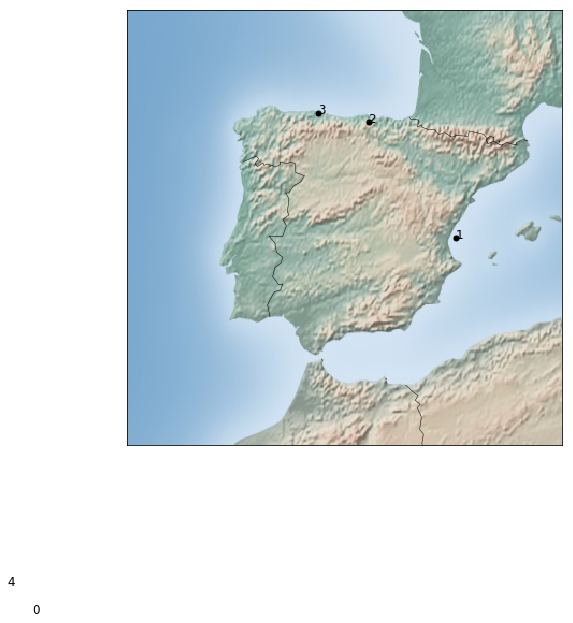

<Figure size 432x288 with 0 Axes>

In [33]:
# Plot interactions on Map
sample_id = 1000 # TODO: Better way to search for appropriate example

configuration = configs[config_indices[sample_id] - config_indices[0]]

plot_interactions(configuration, graphs[sample_id], map=map)

In [ ]:
# Visualize adjacency matrix
fig, axes = plt.subplots(nrows=1, ncols=n_edge_types)
for i in range(n_edge_types):
    im = axes[i].imshow(graphs[sample_id, i, :, :], cmap='gray', interpolation=None)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)

## Let's see how the latent graph changes over time


In [ ]:
window_size = timesteps

dynamic_graphs = []

for step in range(0, 100 - timesteps): #data_tensor.size(-2) - timesteps):
    # Use sliding window to update latent graph over timesteps
    #input = data_tensor[:, :, step:step+timesteps, :]
    #logits = encoder(input, rel_rec, rel_send)
    #edges = gumbel_softmax(logits, tau=0.5, hard=True)
    edges = torch.rand((100, n_atoms * (n_atoms - 1), n_atoms))
    graphs = edges_to_adj(edges, n_atoms=n_atoms)
    dynamic_graphs.append(graphs)

In [ ]:
sample_id = 0

plot_interactions()